# Full SNP calling benchmarks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import json
from pathlib import Path

import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from IPython.display import display, HTML

seaborn.set()
seaborn.set_context("notebook")

In [3]:
BASE_PATH = Path("benchmarks/straingr")

## Load datasets

In [4]:
# Reference contig metadata
ref_contig_map = pandas.read_csv("ref_contig_map.tsv", sep='\t', comment='#', index_col='contig')

### Which references did we use for which sample?

In [5]:
MUTATED_REFS_DIR = BASE_PATH / "mutated_refs"

ref_data = []
for fname in MUTATED_REFS_DIR.glob("**/orig_refs.txt"):
    ref_df = pandas.read_csv(fname, sep='\t', header=None, names=['ref', 'path'])
    
    relpath = fname.relative_to(MUTATED_REFS_DIR)
    data = {
        'sample': str(relpath.parent),
        'sample_type': 'unequal' if 'unequal' in str(relpath.parent) else 'equal',
        **{f'reference{i+1}': ref for i, ref in enumerate(ref_df['ref'])}
    }
    
    ref_data.append(data)
    
ref_df = pandas.DataFrame(ref_data).set_index('sample')
ref_df['num_strains'] = ref_df[['reference1', 'reference2', 'reference3', 'reference4']].notnull().sum(axis=1)

### Load evaluation results

In [6]:
RESULTS_DIR = BASE_PATH / "straingr/"

data = []

for i, path in enumerate(RESULTS_DIR.glob("**/*.stats.csv")):
    rpath = path.relative_to(RESULTS_DIR)
    sample_id = str(rpath.parent.parent)
    ref = path.name.replace(".stats.csv", "")
    
    metrics = pandas.read_csv(path)
    del metrics['sompyversion']
    del metrics['sompycmd']
    del metrics['Unnamed: 0']
    
    metrics['sample'] = sample_id
    metrics['cov'] = rpath.parent.name
    metrics['ref'] = ref
    
    if 'unequal' in sample_id:
        coverages = rpath.parent.name.split('_')
        coverages = [float(c[:-1]) for c in coverages]
    else:
        if rpath.parts[0] == 'single':
            num_strains = 1
        else:
            num_strains = int(rpath.parts[0][-1])
            
        coverages = [float(rpath.parent.name[:-1])] * num_strains
    
    for i, cov in enumerate(coverages):
        metrics[f'coverage{i+1}'] = cov
        
    data.append(metrics)
    
df = pandas.concat(data, sort=True).set_index(['sample', 'cov', 'ref', 'type'])
df = df.loc[(slice(None), slice(None), slice(None), 'SNVs'), :].reset_index(level=3)
df = df.join(ref_df, on='sample')

df['strain_num'] = None
for sample, cov, ref in df.index.unique():
    for i in range(1, 5):
        if ref == df.loc[(sample, cov, ref), f'reference{i}']:
            df.loc[(sample, cov, ref), 'strain_num'] = i
            
            
def get_orig_cov(ix):
    i = df.loc[ix, 'strain_num']
    return df.loc[ix, f'coverage{i}'] if i else None
            
            
df['orig_cov'] = df.index.map(get_orig_cov)

/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2843: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


### Load StrainGR statistics

In [7]:
data = []

for i, path in enumerate(RESULTS_DIR.glob("**/straingr.tsv")):
    rpath = path.relative_to(RESULTS_DIR)
    sample_id = str(rpath.parent.parent)
    cov = str(rpath.parent.name)
    
    if sample_id.startswith('gene_del'):
        continue
    
    metrics = pandas.read_csv(path, sep='\t', comment='#')
    metrics['sample'] = sample_id
    metrics['cov'] = cov
    metrics.index.rename("strain_idx")
    
    data.append(metrics)
        
straingr_df = pandas.concat(data)
straingr_df = straingr_df[straingr_df['ref'] != "TOTAL"]

straingr_df = straingr_df.set_index(['sample', 'cov', 'ref']).sort_index()
straingr_df

name  \
sample            cov     ref                                                             
equal2/equal21    0.1x    Esch_coli_2009EL-2050                             NC_018650.1   
                          Esch_coli_503025                                NZ_CP025892.1   
                  0.5x    Esch_coli_2009EL-2050                             NC_018650.1   
                          Esch_coli_503025                                NZ_CP025892.1   
                  10x     Esch_coli_2009EL-2050                             NC_018650.1   
                          Esch_coli_503025                                NZ_CP025892.1   
                  1x      Esch_coli_2009EL-2050                             NC_018650.1   
                          Esch_coli_503025                                NZ_CP025892.1   
equal2/equal210   0.1x    Esch_coli_C1                                    NZ_CP010116.1   
                          Esch_coli_ER2796                                NZ_CP009644.1   
                  0.5x    Esch_coli_C1                                    NZ_CP010116.1   
                          Esch_coli_ER2796                                NZ_CP009644.1   
                  10x     Esch_coli_C1                                    NZ_CP010116.1   
                          Esch_coli_ER2796                                NZ_CP009644.1   
                  1x      Esch_coli_C1                                    NZ_CP010116.1   
                          Esch_coli_ER2796                                NZ_CP009644.1   
equal2/equal211   0.1x    Esch_coli_2015C-4498                            NZ_CP027552.1   
                          Esch_coli_JJ1887                                NZ_CP014316.1   
                  0.5x    Esch_coli_2015C-4498                            NZ_CP027552.1   
                          Esch_coli_JJ1887                                NZ_CP014316.1   
                  10x     Esch_coli_2015C-4498                            NZ_CP027552.1   
                          Esch_coli_JJ1887                                NZ_CP014316.1   
                  1x      Esch_coli_2015C-4498                            NZ_CP027552.1   
                          Esch_coli_JJ1887                                NZ_CP014316.1   
equal2/equal212   0.1x    Esch_coli_Y5                                    NZ_CP013483.1   
                          Esch_coli_strain_Z247                           NZ_CP021207.1   
                  0.5x    Esch_coli_Y5                                    NZ_CP013483.1   
                          Esch_coli_strain_Z247                           NZ_CP021207.1   
                  10x     Esch_coli_Y5                                    NZ_CP013483.1   
                          Esch_coli_strain_Z247                           NZ_CP021207.1   
...                                                                                 ...   
unequal/unequal20 1x_0.5x Esch_coli_110                                   NZ_CP028687.1   
                          Esch_coli_ECZP248                               NZ_CP034784.1   
unequal/unequal3  10x_1x  Esch_coli_99-3165                               NZ_CP029981.1   
                          Shig_flexneri_0702                              NZ_CP020339.1   
                  1x_0.5x Esch_coli_99-3165                               NZ_CP029981.1   
                          Shig_flexneri_0702                              NZ_CP020339.1   
unequal/unequal4  10x_1x  Esch_coli_06-00048                              NZ_CP015229.1   
                          Esch_coli_E2865                                 NZ_AP018808.1   
                  1x_0.5x Esch_coli_06-00048                              NZ_CP015229.1   
                          Esch_coli_E2865                                 NZ_AP018808.1   
unequal/unequal5  10x_1x  Esch_coli_1943                                  NZ_CP023359.1   
                          Esch_coli_HUSEC2011                             NZ_HF

In [8]:
merged_df = straingr_df.join(df, rsuffix="straingr_").sort_index().reset_index()

## Plot results

### Equal abundance samples

In [9]:
equal_df = merged_df[merged_df['sample_type'] == "equal"].copy()

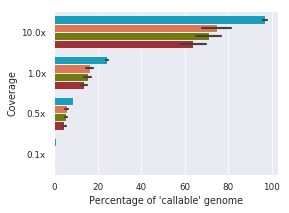

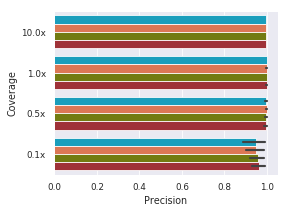

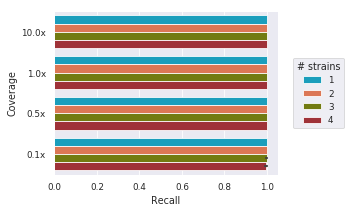

In [19]:
broad_palette = [
    "#00AFD7",
    "#F36C3E",
    "#808C00",
    "#B12028",
    "#FFCD00",
    "#69488E"
]
seaborn.set_context("paper")

cov_order = [10.0, 1.0, 0.5, 0.1]
cov_labels = [f"{cov}x" for cov in cov_order]

plt.figure(figsize=(4, 3))
seaborn.barplot(hue="num_strains", y="orig_cov", x="callablePct", orient="h", order=cov_order,
                data=equal_df[equal_df['sample_type'] != 'unequal'], palette=broad_palette)
plt.legend().remove()
plt.xlabel("Percentage of 'callable' genome")
plt.ylabel("Coverage")
plt.gca().set_yticklabels(labels=cov_labels)
plt.savefig('paper_fig/straingr_snp_equal_callable.png', dpi=256, bbox_inches='tight')
plt.savefig('paper_fig/straingr_snp_equal_callable.svg', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 3))
seaborn.barplot(hue="num_strains", y="orig_cov", x="precision", orient="h", order=cov_order,
                data=equal_df[equal_df['sample_type'] != 'unequal'], palette=broad_palette)
plt.legend().remove()
plt.xlabel("Precision")
plt.ylabel("Coverage")
plt.gca().set_yticklabels(labels=cov_labels)
plt.savefig('paper_fig/straingr_snp_equal_precision.png', dpi=256, bbox_inches='tight')
plt.savefig('paper_fig/straingr_snp_equal_precision.svg', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 3))
seaborn.barplot(hue="num_strains", y="orig_cov", x="recall", orient="h", order=cov_order,
                data=equal_df[equal_df['sample_type'] != 'unequal'], palette=broad_palette)
plt.xlabel("Recall")
plt.ylabel("Coverage")
plt.gca().set_yticklabels(labels=cov_labels)

handles, labels = plt.gca().get_legend_handles_labels()
labels = [
    "1",
    "2",
    "3",
    "4"
]
lgd = plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), title="# strains")
plt.savefig('paper_fig/straingr_snp_equal_recall.png', dpi=256, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('paper_fig/straingr_snp_equal_recall.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


### Unequal abundance mixes

#### 10x:1x

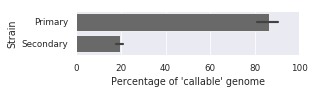

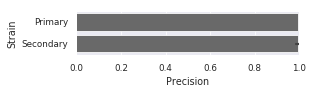

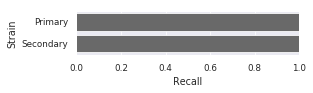

In [27]:
unequal_10x_1x = merged_df[merged_df['cov'] == "10x_1x"]

plt.figure(figsize=(4, 0.8))
seaborn.barplot(x="callablePct", y="strain_num", color="dimgrey", orient="h",
                data=unequal_10x_1x)
plt.xlabel("Percentage of 'callable' genome")
plt.ylabel("Strain")
plt.gca().set_yticklabels(labels=["Primary", "Secondary"], verticalalignment='center')
plt.xlim(0, 100)
plt.savefig('paper_fig/straingr_snp_unequal_callable_10x_1x.svg', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 0.8))
seaborn.barplot(x="precision", y="strain_num", color="dimgrey", orient="h",
                data=unequal_10x_1x)
plt.xlabel("Precision")
plt.ylabel("Strain")
plt.gca().set_yticklabels(labels=["Primary", "Secondary"], verticalalignment='center')
plt.xlim(0, 1.0)
plt.savefig('paper_fig/straingr_snp_unequal_precision_10x_1x.svg', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 0.8))
seaborn.barplot(x="recall", y="strain_num", color="dimgrey",orient="h",
                data=unequal_10x_1x)
plt.xlabel("Recall")
plt.ylabel("Strain")
plt.gca().set_yticklabels(labels=["Primary", "Secondary"], verticalalignment='center')
plt.xlim(0, 1.0)
plt.savefig('paper_fig/straingr_snp_unequal_recall_10x_1x.svg', bbox_inches='tight')
plt.show()


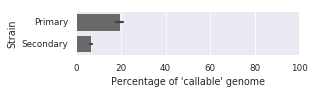

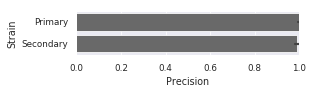

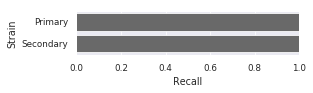

In [29]:
unequal_1x_05x = merged_df[merged_df['cov'] == "1x_0.5x"]

plt.figure(figsize=(4, 0.8))
seaborn.barplot(x="callablePct", y="strain_num", color="dimgrey", orient="h",
                data=unequal_1x_05x)
plt.xlabel("Percentage of 'callable' genome")
plt.ylabel("Strain")
plt.gca().set_yticklabels(labels=["Primary", "Secondary"], verticalalignment='center')
plt.xlim(0, 100)
plt.savefig('paper_fig/straingr_snp_unequal_callable_1x_05x.svg', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 0.8))
seaborn.barplot(x="precision", y="strain_num", color="dimgrey", orient="h",
                data=unequal_1x_05x)
plt.xlabel("Precision")
plt.ylabel("Strain")
plt.gca().set_yticklabels(labels=["Primary", "Secondary"], verticalalignment='center')
plt.xlim(0, 1.0)
plt.savefig('paper_fig/straingr_snp_unequal_precision_1x_05x.svg', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 0.8))
seaborn.barplot(x="recall", y="strain_num", color="dimgrey",orient="h",
                data=unequal_1x_05x)
plt.xlabel("Recall")
plt.ylabel("Strain")
plt.gca().set_yticklabels(labels=["Primary", "Secondary"], verticalalignment='center')
plt.xlim(0, 1.0)
plt.savefig('paper_fig/straingr_snp_unequal_recall_1x_05x.svg', bbox_inches='tight')
plt.show()


## Combined equal/unequal plot

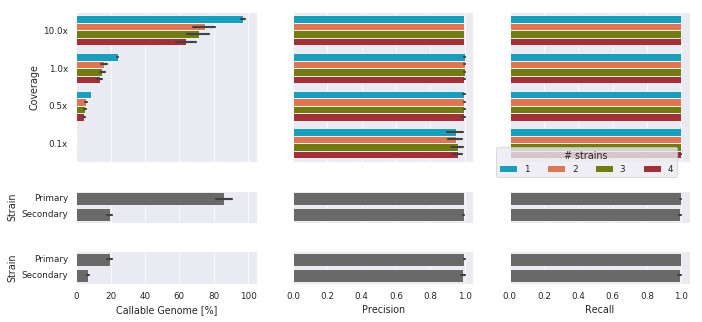

In [63]:
seaborn.set_context("paper")
fig, axes = plt.subplots(3, 3, figsize=(11, 5), sharex='col', sharey='row', gridspec_kw={"height_ratios": [7, 1.5, 1.5]})


cov_order = [10.0, 1.0, 0.5, 0.1]
cov_labels = [f"{cov}x" for cov in cov_order]

# Equal abundance plots
seaborn.barplot(hue="num_strains", y="orig_cov", x="callablePct", orient='h', order=cov_order,
                data=equal_df[equal_df['sample_type'] != 'unequal'], palette=broad_palette, ax=axes[0, 0])
axes[0, 0].legend().remove()
axes[0, 0].set_xlabel("")
axes[0, 0].set_xlim(0, 105)
axes[0, 0].set_ylabel("Coverage")
axes[0, 0].set_yticklabels(labels=cov_labels)

seaborn.barplot(hue="num_strains", y="orig_cov", x="precision", orient='h', order=cov_order,
                data=equal_df[equal_df['sample_type'] != 'unequal'], palette=broad_palette, ax=axes[0, 1])
axes[0, 1].legend().remove()
axes[0, 1].set_xlabel("")
axes[0, 1].set_xlim(0, 1.05)
axes[0, 1].set_ylabel("")
axes[0, 1].set_yticklabels(labels=cov_labels)

seaborn.barplot(hue="num_strains", y="orig_cov", x="recall", orient='h', order=cov_order,
                data=equal_df[equal_df['sample_type'] != 'unequal'], palette=broad_palette, ax=axes[0, 2])
axes[0, 2].set_xlabel("")
axes[0, 2].set_xlim(0, 1.05)
axes[0, 2].set_ylabel("")
axes[0, 2].set_yticklabels(labels=cov_labels)

handles, labels = axes[0, 2].get_legend_handles_labels()
labels = [
    "1",
    "2",
    "3",
    "4"
]
lgd = axes[0, 2].legend(handles, labels, loc='center right', bbox_to_anchor=(0.95, 0.0), title="# strains", ncol=4)

# Unequal abundance 10x:1x
seaborn.barplot(x="callablePct", y="strain_num", color="dimgrey", orient='h', order=[1, 2],
                data=unequal_10x_1x, ax=axes[1, 0])
axes[1, 0].set_yticks([1, 2], minor=True)
axes[1, 0].set_yticklabels(labels=["Primary", "Secondary"], verticalalignment='center')
axes[1, 0].set_ylabel("Strain")
axes[1, 0].set_xlabel("")

seaborn.barplot(x="precision", y="strain_num", color="dimgrey", orient='h', order=[1, 2],
                data=unequal_10x_1x, ax=axes[1, 1])
axes[1, 1].set_yticklabels(labels=["Primary", "Secondary"], verticalalignment='center')
axes[1, 1].set_ylabel("")
axes[1, 1].set_xlabel("")

seaborn.barplot(x="precision", y="strain_num", color="dimgrey", orient='h', order=[1, 2],
                data=unequal_10x_1x, ax=axes[1, 2])
axes[1, 2].set_yticklabels(labels=["Primary", "Secondary"], verticalalignment='center')
axes[1, 2].set_ylabel("")
axes[1, 2].set_xlabel("")

# Unequal abundance 1x:0.5x
seaborn.barplot(x="callablePct", y="strain_num", color="dimgrey", orient='h', order=[1, 2],
                data=unequal_1x_05x, ax=axes[2, 0])
axes[2, 0].set_yticks([1, 2], minor=True)
axes[2, 0].set_yticklabels(labels=["Primary", "Secondary"], verticalalignment='center')
axes[2, 0].set_ylabel("Strain")
axes[2, 0].set_xlabel("Callable Genome [%]")

seaborn.barplot(x="precision", y="strain_num", color="dimgrey", orient='h', order=[1, 2],
                data=unequal_1x_05x, ax=axes[2, 1])
axes[2, 1].set_ylabel("")
axes[2, 1].set_yticklabels(labels=["Primary", "Secondary"], verticalalignment='center')
axes[2, 1].set_xlabel("Precision")

seaborn.barplot(x="precision", y="strain_num", color="dimgrey", orient='h', order=[1, 2],
                data=unequal_1x_05x, ax=axes[2, 2])
axes[2, 2].set_ylabel("")
axes[2, 2].set_yticklabels(labels=["Primary", "Secondary"], verticalalignment='center')
axes[2, 2].set_xlabel("Recall")

fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.savefig('paper_fig/straingr_snp_benchmarks.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.show()

In [19]:
equal_df[equal_df['orig_cov'] != "0.1x"]['precision'].mean()

/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


0.9864349904854899